# Webscrapen en visualiseren
Ik heb ervoor gekozen de vacatures op de website van YoungCapital te webscrapen en te visualiseren in welke provincies de meeste vacatures te vinden zijn en waar de hoogste salarissen zijn.

In [1]:
# Om te beginnen maak ik gebruik van de modules
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

## Functie voor het ophalen van de webpages

In [2]:
# Met behulp van de requests library wordt de webpagina opgehaald, met beautifulsoup wordt de page source omgezet in
# bruikbare vorm
def pagina_ophalen(pagina_nummer):
    path = fr'https://www.youngcapital.nl/vacatures?page={pagina_nummer}&search%5Bfunction_id%5D=&search%5Bpage%5D=&search%5Bsort_by%5D='
    response = requests.get(path)
    soup = BeautifulSoup(response.text, 'html.parser')
    return soup

## Functie voor het bepalen van het aantal te bezoeken pagina's

In [3]:
# De eerste pagina wordt opgehaald en het aantal vacatures wordt bepaald. Deze functie wordt later gebruikt om het aantal
# te scrapen pagina's te bepalen.
def aantal_paginas_bepalen():
    
    
    soup = pagina_ophalen(1)
    resultaten = soup.find('b')
    # Het aantal vacatures wordt in het <b> element gevonden en mbv regex omgezet in een integer
    aantal = int(re.findall(r'\d+', soup.find('b').text)[0])
    paginas = int(aantal / 30) + (aantal % 30 > 0)
    
    # de gebruiker kan ingeven hoeveel paginas er moeten worden opgevraagd, met uiteraard niet meer dan het maximale
    # mogelijke aantal. Alleen integers onder het maximum aantal worden geaccepteerd.
    while True:
        try:
            user_paginas = int(input(f"Hoeveel paginas wil je ophalen? Maximaal: {paginas} paginas \n"))
            if user_paginas > paginas:
                continue
            paginas = user_paginas
            break
        except ValueError:
            continue
    
    return paginas

## Scrapen
Na de eerste kunnen ook de 140-150 verdere pagina's opgehaald

In [4]:
def vacatures_ophalen():
    # er wordt een lege lijst gemaakt waaraan de vacatures zullen worden toegevoegd
    vacatures = []
    aantal_paginas = aantal_paginas_bepalen()
    for page_number in range(1, aantal_paginas+1):
        # elke pagina wordt opgehaald en in een soup omgezet
        soup = pagina_ophalen(page_number)
        # de omschrijving van de vacature wordt gevonden
        omschrijving = soup.find_all('h3', {"class" : "text--bold"})
        # stad, salaris en dienstverband worden uit het div element met class 'start-xs top-xs mt-2x mb-2x' gehaald
        entries = soup.find_all("div", {"class" : 'start-xs top-xs mt-2x mb-2x'})
        for number, entry in enumerate(entries):
            # voor elke vacature wordt ook weer een lijst aangemaakt om de informatie te ordenen
            vacature = []
            # omschrijving toevoegen
            vacature.append(omschrijving[number].text)
            # stad + salaris + dienstverband toevoegen
            for beschrijving in (entry.find_all('span', {"class" : "mr-6x mr-sm-2x"})):
                vacature.append(beschrijving.text)
            # als het salaris ontbreekt wordt er 'onbekend' als salaris aangegeven
            if len(vacature) < 4:
                vacature.insert(2, 'onbekend')
            # de vacature wordt aan de lijst met vacatures toegevoegd
            vacatures.append(vacature)
    # de lijst met vacatures wordt terug doorgegeven
    return vacatures

## Dataframe aanmaken
De voor ons relevante informatie wordt in een dataframe geplaatst. Omdat een vacature meerdere plaatsaanduidingen kan hebben, worden deze gesplitst.

In [5]:
def vacatures_in_dataframe_omzetten(vacatures):
    stad_list = []
    salaris_list = []
    dienstverband_list = []
    # er wordt gelooped over elke vacature
    for entry in vacatures:
        # er wordt gelooped over elke stad in elke vacature
        for stad in entry[1].split(','):
            # landelijk wordt niet meegenomen
            if 'Landelijk' in stad:
                continue
            stad_list.append(stad)
            salaris_list.append(entry[2])
            dienstverband_list.append(entry[3])
            
    # de verschillende lijsten worden in een dataframe verzameld
    output_dataframe = pd.DataFrame([stad_list, salaris_list, dienstverband_list], index = ['stad','salaris','dienstverband']).T
    return output_dataframe

dataframe = vacatures_in_dataframe_omzetten(vacatures_ophalen())

Hoeveel paginas wil je ophalen? Maximaal: 145 paginas 
10


## Salaris cijfers schoonmaken
De salaris cijfers zijn op dit moment niet in een voor ons bruikbaar format opgeslagen. Deze strings moeten worden omgezet in floats om werkbaar te worden gemaakt. Verder wordt salaris per uur omgezet in salaris per maand en wordt het gemiddelde bepaald als er twee verschillende waarden zijn.

In [6]:
def clean_salary(salaris, dienstverband):
    # omzetting per uur
    if 'uur' in salaris:
        # de getallen worden uit de string gehaald
        cijfers = re.findall(r'\d+', salaris)
        
        # als er 4 verschillende getallen zijn, betekent dit dat er een spreiding is. Hiervoor wordt het gemiddelde uitgerekend
        if len(cijfers) == 4:
            salaris_per_uur = (float('.'.join(cijfers[0:2])) + float('.'.join(cijfers[2:4]))) / 2
        
        # bij 2 verschillende getallen hoeft er geen gemiddelde te worden uitgerekend
        elif (len(cijfers) == 2):
            salaris_per_uur = float('.'.join(cijfers[0:2]))
        
        # hier ontdekte ik een fout in een van de vacatures, waarin 2100 tot 2200 euro per uur staat
        if (len(cijfers)) == 6:
            return 'onbekend'
            
        # fulltime dienstverband (40 uur) is ca. 173 keer het uursalaris
        if 'Fulltime' in dienstverband:
            salaris_per_maand = salaris_per_uur * 173
        # voor parttime heb ik 24 uur genomen, wat neerkomt op ca 104 uur per maand
        else:
            salaris_per_maand = salaris_per_uur * 104
        
        try:
            return salaris_per_maand
        except UnboundLocalError:
            'Vacature met afwijkend format geskipt'
    
    if 'maand' in salaris:
        # ook voor de salarissen die al in maand uitgedrukt waren wordt dit gedaan
        cijfers = re.findall(r'\d+', salaris)
        # gemiddelde uitrekenen bij 4 getallen
        if len(cijfers) == 4:
            salaris_per_maand = (float(''.join(cijfers[0:2])) + float(''.join(cijfers[2:4]))) / 2
        # bij 2 getallen 
        if len(cijfers) == 2:
            salaris_per_maand = float(''.join(cijfers[0:2]))
            
        try:
            return salaris_per_maand
        except UnboundLocalError:
            'Vacature met afwijkend format geskipt'
    
    # als er geen 'uur' of 'maand' in het salaris wordt gevonden is het salaris onbekend, dit blijft ongewijzigd
    salaris_per_maand = salaris
    
    return salaris_per_maand

# De salaris waarden worden geupdate dmv de apply functie
dataframe['salaris'] = dataframe.apply(lambda x: clean_salary(x['salaris'], x['dienstverband']), axis = 1)

## provincie toewijzen
Voor het toewijzen van de provincie aan de hand van de steden wordt er gebruik gemaakt van de API positionstack.

In [7]:
def provincie_lookup(stad):
    # API key
    access_key = '573e3d2c8d0b53ac42e5906aac12b2f3'
    # Te bepalen stad
    query = stad
    country = 'NL'
    # Ik wil maar 1 resultaat terugkrijgen
    limit = '1'
    
    # url van de API, waarin de query de stad aangeeft
    base_url = (f"http://api.positionstack.com/v1/forward?access_key={access_key}"
                f"&query={query}&country={country}&limit={limit}")
    
    # dmv de requests module wordt er een response object opgevraagd
    antwoord = requests.get(base_url)    
    # dit object wordt als json ingelezen
    data = antwoord.json()
    # de provincie is waar we naar op zoek zijn, deze is hier te vinden in het json object
    provincie = data['data'][0]['region']
    
    return provincie

# per stad wordt de provincie toegewezen
dataframe['provincie'] = dataframe.apply(lambda x: provincie_lookup(x['stad']), axis = 1)

## Aantal vacatures
Het aantal vacatures per provincie wordt bepaald dmv de groupby functie

In [8]:
aantal_per_provincie = dataframe.groupby(['provincie']).stad.count().reset_index()
aantal_per_provincie.rename(columns = {'stad' : 'aantal'}, inplace=True)

## Kaart plotten
Om deze cijfers te plotten op een kaart wordt de geopandas module gebruikt, met een kaart van Nederland

In [9]:
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
# url voor het ophalen van de kaart
mapdf = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")

In [10]:
# alleen de provincies zijn relevant, de meren niet
mapdf = mapdf[mapdf["TYPE_1"] == "Provincie"]
# het geo dataframe en dataframe met informatie worden samengevoegd 
mapdf = gpd.GeoDataFrame(mapdf.merge(aantal_per_provincie, left_on = 'NAME_1', right_on = aantal_per_provincie.provincie))

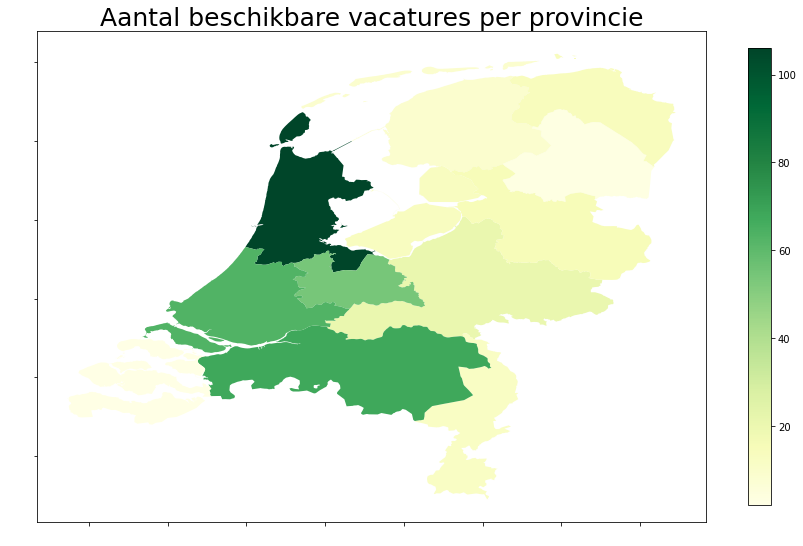

In [11]:
from matplotlib import pyplot as plt

# de informatie in de `aantal` kolom wordt geplot op de kaart van Nederland
mapdf.plot(column=aantal_per_provincie.aantal, figsize=(15,14), legend=True, cmap='YlGn', legend_kwds={'shrink': 0.6})
plt.xticks(color = 'w')
plt.yticks(color = 'w')
plt.title('Aantal beschikbare vacatures per provincie', fontsize = 25)

plt.show()

In [12]:
# Overzicht van het aantal vacatures per provincie
aantal_per_provincie.sort_values(by='aantal', ascending=False).set_index('provincie')

,aantal
provincie,
Noord-Holland,106
Noord-Brabant,68
Zuid-Holland,63
Utrecht,54
Gelderland,21
Overijssel,15
Groningen,14
Flevoland,13
Limburg,12


## Salaris per provincie
Ditzelfde wordt gedaan voor het gemiddeld salaris per provincie.

In [13]:
# Alleen de numerieke waarden zijn relevant
zonder_onbekend = dataframe[dataframe.salaris.map(type) == float]
# Met behulp van groupby wordt het gemiddelde per provincie uitgerekend
gemiddeld_salaris_per_provincie = zonder_onbekend.groupby(['provincie']).salaris.mean().reset_index()

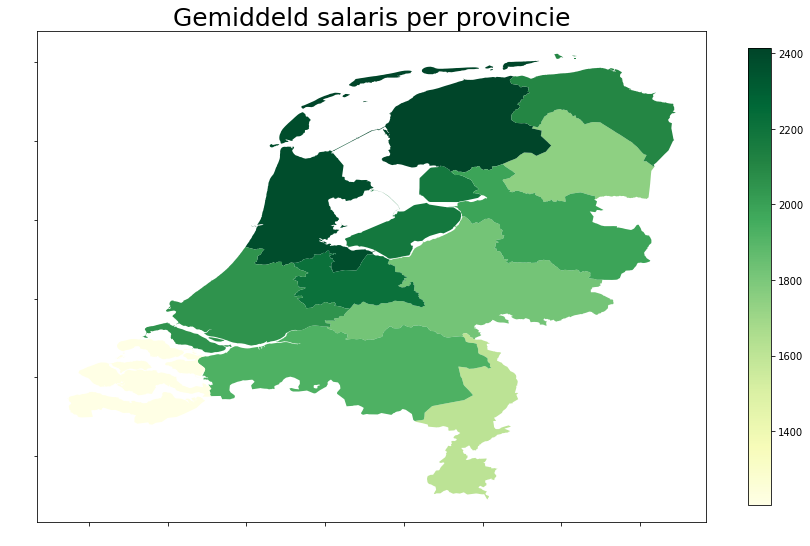

In [14]:
from matplotlib import pyplot as plt

# Wederom plotten op de kaart
mapdf.plot(column=gemiddeld_salaris_per_provincie.salaris, figsize=(15,14), legend=True, cmap='YlGn', legend_kwds={'shrink': 0.6})
plt.xticks(color = 'w')
plt.yticks(color = 'w')
plt.title('Gemiddeld salaris per provincie', fontsize = 25)

plt.show()

In [15]:
gemiddeld_salaris_per_provincie.sort_values(by = 'salaris', ascending=False).set_index('provincie')

,salaris
provincie,
Friesland,2413.340000
Noord-Holland,2378.577174
Utrecht,2213.862642
Flevoland,2175.244000
Groningen,2105.592000
Zuid-Holland,2053.822364
Overijssel,1985.251786
Noord-Brabant,1924.840484
Gelderland,1820.771579
